This runs all segmentation operations in one place.
The idea is that this should be faster and easier to invoke as we only have to load the image data once instead of N times (~10).
Running each individual task as its own script is modular but requires overhead to load the data each time.
Currently it takes about 15 minutes to complete a single organoid's segmentation for all compartments... (~50,1500,1500) (Z,Y,X) dimensional image. 

In [1]:
import argparse
import os
import pathlib
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import skimage
import tifffile
import torch
from arg_parsing_utils import check_for_missing_args, parse_args
from cellpose import models
from file_reading import find_files_available, read_in_channels, read_zstack_image
from general_segmentation_utils import *
from notebook_init_utils import bandicoot_check, init_notebook
from nuclei_segmentation import *
from read_in_channel_mapping import *
from segmentation_decoupling import *
from skimage.filters import sobel
from skimage.segmentation import relabel_sequential

In [2]:
start_time = time.time()
# get starting memory (cpu)
start_mem = psutil.Process(os.getpid()).memory_info().rss / 1024**2

In [3]:
root_dir, in_notebook = init_notebook()

image_base_dir = bandicoot_check(
    pathlib.Path(os.path.expanduser("~/mnt/bandicoot")).resolve(), root_dir
)

In [4]:
if not in_notebook:
    args = parse_args()
    clip_limit = args["clip_limit"]
    well_fov = args["well_fov"]
    patient = args["patient"]
    input_subparent_name = args["input_subparent_name"]
    mask_subparent_name = args["mask_subparent_name"]
    check_for_missing_args(
        well_fov=well_fov,
        patient=patient,
        clip_limit=clip_limit,
        input_subparent_name=input_subparent_name,
        mask_subparent_name=mask_subparent_name,
    )
else:
    print("Running in a notebook")
    patient = "NF0014_T1"
    well_fov = "D2-1"
    window_size = 3
    clip_limit = 0.01
    input_subparent_name = "zstack_images"
    mask_subparent_name = "segmentation_masks"


input_dir = pathlib.Path(
    f"{image_base_dir}/data/{patient}/{input_subparent_name}/{well_fov}"
).resolve(strict=True)
mask_path = pathlib.Path(
    f"{image_base_dir}/data/{patient}/{mask_subparent_name}/{well_fov}"
).resolve()
mask_path.mkdir(exist_ok=True, parents=True)
channel_dict = retrieve_channel_mapping(f"{root_dir}/data/channel_mapping.toml")

Running in a notebook


In [5]:
return_dict = read_in_channels(
    find_files_available(input_dir),
    channel_dict=channel_dict,
    channels_to_read=["DNA"],
)


nuclei_raw = return_dict["DNA"]
# run clip_limit here
nuclei = skimage.exposure.equalize_adapthist(
    nuclei_raw, clip_limit=clip_limit, kernel_size=None
)
del nuclei_raw

## Nuclei Segmentation

In [6]:
from collections import defaultdict

import networkx as nx
import numpy as np
import pandas as pd
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist


def build_complete_bipartite_graph(masks_2d, distance_threshold=None):
    """
    Build a complete bipartite graph from 2D segmentation masks.

    For each pair of consecutive slices, connect EVERY object in slice N
    to EVERY object in slice N+1, computing Euclidean distance between centroids.

    Args:
        masks_2d: List of 2D segmentation masks (numpy arrays)
        distance_threshold: Optional maximum distance to include edges.
                           If None, ALL pairs are connected (truly complete).

    Returns:
        G: NetworkX graph
        df: DataFrame with all edges
    """
    from scipy import ndimage

    G = nx.Graph()
    edges_data = []

    # For each slice, find all objects and their centroids
    slice_objects = {}

    for z, mask in enumerate(masks_2d):
        unique_ids = np.unique(mask)
        unique_ids = unique_ids[unique_ids > 0]  # Remove background

        if len(unique_ids) == 0:
            slice_objects[z] = {}
            continue

        centroids = ndimage.center_of_mass(mask, labels=mask, index=unique_ids)

        slice_objects[z] = {}
        for obj_id, centroid in zip(unique_ids, centroids):
            slice_objects[z][obj_id] = centroid
            G.add_node(
                f"z{z}_id{obj_id}", slice=z, original_label=obj_id, coordinates=centroid
            )

    # Build complete bipartite graph between consecutive slices
    for z in range(len(masks_2d) - 1):
        if z not in slice_objects or (z + 1) not in slice_objects:
            continue

        curr_objects = slice_objects[z]
        next_objects = slice_objects[z + 1]

        if not curr_objects or not next_objects:
            continue

        curr_ids = list(curr_objects.keys())
        next_ids = list(next_objects.keys())

        curr_centroids = np.array([curr_objects[id] for id in curr_ids])
        next_centroids = np.array([next_objects[id] for id in next_ids])

        # Compute all pairwise distances
        distances = cdist(curr_centroids, next_centroids, metric="euclidean")

        # Add edges for ALL pairs (truly complete graph)
        for i, curr_id in enumerate(curr_ids):
            for j, next_id in enumerate(next_ids):
                dist = distances[i, j]

                # Note: distance_threshold is now NOT applied here
                # (use greedy matching threshold instead)

                curr_node = f"z{z}_id{curr_id}"
                next_node = f"z{z + 1}_id{next_id}"

                G.add_edge(
                    curr_node,
                    next_node,
                    weight=dist,
                    slice1=z,
                    slice2=z + 1,
                    original_label1=curr_id,
                    original_label2=next_id,
                )

                edges_data.append(
                    {
                        "index1": curr_node,
                        "index2": next_node,
                        "slice1": z,
                        "slice2": z + 1,
                        "original_label1": curr_id,
                        "original_label2": next_id,
                        "distance": dist,
                        "coordinates1": curr_objects[curr_id],
                        "coordinates2": next_objects[next_id],
                    }
                )

    df = pd.DataFrame(edges_data)
    return G, df


def solve_graph_improved(G, max_distance=100.0, slices=None, verbose=False):
    """
    Solve bipartite matching across consecutive slices using greedy matching
    based on edge weights (distances).

    Instead of Hungarian algorithm (which can force bad matches), greedily match
    objects in order of smallest distance. This ensures we only connect objects
    that are genuinely close.

    Args:
        G: NetworkX graph with edges between different slices
        max_distance: Maximum distance to accept a match.
        slices: Optional list of slice numbers to process
        verbose: Print debugging info

    Returns:
        List of paths, where each path is a list of node IDs
    """

    if G.number_of_nodes() == 0:
        return []

    # Get unique slices from nodes
    all_slices = set()
    for node in G.nodes():
        slice_id = G.nodes[node]["slice"]
        all_slices.add(slice_id)

    slices = sorted(all_slices)

    if len(slices) < 2:
        # Only one slice, each node is its own path
        return [[node] for node in G.nodes()]

    # For each slice, store its nodes
    slice_to_nodes = defaultdict(list)
    for node in G.nodes():
        slice_id = G.nodes[node]["slice"]
        slice_to_nodes[slice_id].append(node)

    # Track assignments across slices
    node_to_trajectory = {}
    trajectory_id_counter = 0
    trajectories = defaultdict(list)

    # Match consecutive slices
    for i in range(len(slices) - 1):
        curr_slice = slices[i]
        next_slice = slices[i + 1]

        curr_nodes = sorted(slice_to_nodes[curr_slice])
        next_nodes = sorted(slice_to_nodes[next_slice])

        if not curr_nodes or not next_nodes:
            continue

        # Get all edges between these slices, sorted by weight
        edges = []
        for curr_node in curr_nodes:
            for next_node in next_nodes:
                if G.has_edge(curr_node, next_node):
                    weight = G[curr_node][next_node]["weight"]
                    edges.append((weight, curr_node, next_node))

        if not edges:
            if verbose:
                print(f"Warning: No edges between slice {curr_slice} and {next_slice}")
            continue

        # Sort by distance (smallest first)
        edges.sort(key=lambda x: x[0])

        matched_curr = set()
        matched_next = set()

        # Priority 1: Match nodes that already have trajectories (prefer continuity)
        priority_edges = []
        new_edges = []

        for dist, curr_node, next_node in edges:
            if dist > max_distance:
                continue
            if curr_node in matched_curr or next_node in matched_next:
                continue

            # Prioritize edges where curr_node already has a trajectory
            if curr_node in node_to_trajectory:
                priority_edges.append((dist, curr_node, next_node))
            else:
                new_edges.append((dist, curr_node, next_node))

        # Match priority edges first (continues existing trajectories)
        for dist, curr_node, next_node in priority_edges:
            if curr_node in matched_curr or next_node in matched_next:
                continue

            traj_id = node_to_trajectory[curr_node]
            node_to_trajectory[next_node] = traj_id
            trajectories[traj_id].append(next_node)
            matched_curr.add(curr_node)
            matched_next.add(next_node)

        # Then match new edges (start new trajectories)
        for dist, curr_node, next_node in new_edges:
            if curr_node in matched_curr or next_node in matched_next:
                continue

            traj_id = trajectory_id_counter
            trajectory_id_counter += 1
            trajectories[traj_id].append(curr_node)
            trajectories[traj_id].append(next_node)
            node_to_trajectory[curr_node] = traj_id
            node_to_trajectory[next_node] = traj_id
            matched_curr.add(curr_node)
            matched_next.add(next_node)

        # Create new trajectories for unmatched next_nodes
        for next_node in next_nodes:
            if next_node not in matched_next and next_node not in node_to_trajectory:
                trajectories[trajectory_id_counter] = [next_node]
                node_to_trajectory[next_node] = trajectory_id_counter
                trajectory_id_counter += 1

    # Add any untracked nodes as single-node paths
    for node in G.nodes():
        if node not in node_to_trajectory:
            trajectories[trajectory_id_counter] = [node]
            trajectory_id_counter += 1

    return list(trajectories.values())


def split_long_trajectories(paths, max_length):
    """
    Split trajectories that exceed max_length into shorter ones.

    Args:
        paths: List of node paths
        max_length: Maximum number of consecutive nodes per trajectory

    Returns:
        List of split trajectories
    """
    split_paths = []

    for path in paths:
        if len(path) <= max_length:
            split_paths.append(path)
        else:
            # Split into chunks of max_length
            for i in range(0, len(path), max_length):
                chunk = path[i : i + max_length]
                if chunk:
                    split_paths.append(chunk)

    return split_paths


def collapse_labels_from_paths(masks_2d, paths):
    """
    Assign unified labels based on trajectories.

    Args:
        masks_2d: List of 2D masks
        paths: List of node paths from solve_graph_improved

    Returns:
        List of 3D masks with unified labels
    """
    # Create mapping from node ID to trajectory label
    node_to_label = {}
    for label_id, path in enumerate(paths):
        for node_id in path:
            node_to_label[node_id] = label_id

    # Relabel each 2D mask
    relabeled_masks = []
    for z, mask in enumerate(masks_2d):
        new_mask = np.zeros_like(mask)

        unique_ids = np.unique(mask)
        unique_ids = unique_ids[unique_ids > 0]

        for obj_id in unique_ids:
            node_id = f"z{z}_id{obj_id}"
            if node_id in node_to_label:
                new_label = node_to_label[node_id]
                new_mask[mask == obj_id] = new_label

        relabeled_masks.append(new_mask)

    return relabeled_masks


def stack_3d_segmentation(relabeled_masks):
    """Stack 2D relabeled masks into 3D volume."""
    return np.stack(relabeled_masks, axis=0)


def remove_single_slice_objects(segmentation_3d):
    """
    Remove objects that only appear in a single z-slice.

    Args:
        segmentation_3d: 3D segmentation array

    Returns:
        Cleaned 3D segmentation with single-slice objects removed
    """
    cleaned = segmentation_3d.copy()

    # Find all unique labels
    unique_labels = np.unique(segmentation_3d)
    unique_labels = unique_labels[unique_labels > 0]

    # For each label, count how many slices it appears in
    for label in unique_labels:
        slices_with_label = np.where(np.any(segmentation_3d == label, axis=(1, 2)))[0]

        # If label only appears in 1 slice, remove it
        if len(slices_with_label) == 1:
            cleaned[segmentation_3d == label] = 0

    return cleaned


def fill_object_gaps(segmentation_3d, max_gap_size=2):
    """
    Fill gaps in object trajectories (missing slices between appearances).

    For example, if object ID 5 appears in slices [10, 11, 14, 15],
    the gap between 11 and 14 will be filled if gap_size <= max_gap_size.

    Args:
        segmentation_3d: 3D segmentation array
        max_gap_size: Maximum number of consecutive missing slices to fill
                     (default: 2, meaning fill gaps of 1-2 slices)

    Returns:
        Filled 3D segmentation
    """
    filled = segmentation_3d.copy()

    # Find all unique labels
    unique_labels = np.unique(segmentation_3d)
    unique_labels = unique_labels[unique_labels > 0]

    for label in unique_labels:
        # Find all slices where this label appears
        slices_with_label = np.where(np.any(segmentation_3d == label, axis=(1, 2)))[0]

        if len(slices_with_label) < 2:
            continue

        # Check for gaps and fill them
        for i in range(len(slices_with_label) - 1):
            curr_slice = slices_with_label[i]
            next_slice = slices_with_label[i + 1]
            gap_size = next_slice - curr_slice - 1

            # If gap is small enough, fill it by interpolating from neighbors
            if 0 < gap_size <= max_gap_size:
                # Get the mask from current and next slice
                curr_mask = segmentation_3d[curr_slice] == label
                next_mask = segmentation_3d[next_slice] == label

                # Interpolate: use union of both masks for gap slices
                combined_mask = curr_mask | next_mask

                for gap_slice in range(curr_slice + 1, next_slice):
                    filled[gap_slice][combined_mask] = label

    return filled


def postprocess_segmentation(
    segmentation_3d, remove_singletons=True, fill_gaps=True, max_gap_size=2
):
    """
    Post-process 3D segmentation to clean up artifacts.

    Args:
        segmentation_3d: 3D segmentation array
        remove_singletons: If True, remove objects that only appear in 1 slice
        fill_gaps: If True, fill small gaps in object trajectories
        max_gap_size: Maximum gap size to fill (only used if fill_gaps=True)

    Returns:
        Cleaned 3D segmentation
    """
    result = segmentation_3d.copy()

    if remove_singletons:
        result = remove_single_slice_objects(result)

    if fill_gaps:
        result = fill_object_gaps(result, max_gap_size)

    return result


def full_pipeline(
    masks_2d, max_match_distance=100.0, max_trajectory_length=None, verbose=True
):
    """
    Complete pipeline: build complete bipartite graph -> solve matching -> relabel.

    Args:
        masks_2d: List of 2D segmentation masks
        max_match_distance: Maximum distance to accept a match (in pixels).
        max_trajectory_length: Optional maximum number of consecutive slices an object
                              can span. If None, no limit. Use to prevent unrealistic
                              tall objects (e.g., set to 10 if cells shouldn't span >10 slices).
        verbose: Print diagnostics

    Returns:
        segmentation_3d: 3D array with unified instance labels across slices
        diagnostics: Dict with stats about the matching
    """
    if verbose:
        print("Building complete bipartite graph...")
    G, df = build_complete_bipartite_graph(masks_2d)

    if verbose:
        print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
        print(f"\nDistance statistics:")
        if len(df) > 0:
            print(f"  Mean distance: {df['distance'].mean():.2f}")
            print(f"  Median distance: {df['distance'].median():.2f}")
            print(f"  Std dev: {df['distance'].std():.2f}")
            print(f"  Min: {df['distance'].min():.2f}, Max: {df['distance'].max():.2f}")
            print(f"  25th percentile: {df['distance'].quantile(0.25):.2f}")
            print(f"  75th percentile: {df['distance'].quantile(0.75):.2f}")

    if verbose:
        print(
            f"\nSolving bipartite matching (max_match_distance={max_match_distance})..."
        )

    paths = solve_graph_improved(G, max_distance=max_match_distance, verbose=verbose)

    # Post-process: split trajectories that are too long
    if max_trajectory_length is not None:
        paths = split_long_trajectories(paths, max_trajectory_length)

    diagnostics = {
        "num_trajectories": len(paths),
        "trajectory_lengths": [len(p) for p in paths],
        "mean_trajectory_length": np.mean([len(p) for p in paths]),
        "distance_stats": {
            "mean": df["distance"].mean() if len(df) > 0 else 0,
            "median": df["distance"].median() if len(df) > 0 else 0,
            "std": df["distance"].std() if len(df) > 0 else 0,
        },
    }

    if verbose:
        print(f"Found {len(paths)} trajectories")
        print(
            f"  Mean trajectory length: {diagnostics['mean_trajectory_length']:.2f} slices"
        )
        print(f"  Max trajectory length: {max(diagnostics['trajectory_lengths'])}")
        single_slice = sum(1 for p in paths if len(p) == 1)
        print(f"  Single-slice trajectories: {single_slice}")
        print("Relabeling masks...")

    relabeled_masks = collapse_labels_from_paths(masks_2d, paths)

    if verbose:
        print("Stacking into 3D volume...")

    segmentation_3d = stack_3d_segmentation(relabeled_masks)

    # Post-process: remove single-slice objects and fill small gaps
    segmentation_3d = postprocess_segmentation(
        segmentation_3d, remove_singletons=True, fill_gaps=True, max_gap_size=2
    )

    return segmentation_3d, diagnostics

In [7]:
nuclei_image_shape = nuclei.shape
nuclei_masks = np.array(  # convert to array
    list(  # send to list
        decouple_masks(  # 4. decouple masks
            reverse_sliding_window_max_projection(  # 3. reverse sliding window
                segmentaion_on_two_D(  # 2. segment on 2D
                    sliding_window_two_point_five_D(  # 1. run sliding window
                        image_stack=nuclei, window_size=3
                    )
                ),
                window_size=3,
                original_z_slice_count=nuclei_image_shape[0],
            ),
            original_img_shape=nuclei_image_shape,
            distance_threshold=10,
        ).values()
    )
)

100%|██████████| 27/27 [00:27<00:00,  1.00s/it]


## remove small masks in each slice

In [8]:
for z in range(nuclei_masks.shape[0]):
    nuclei_masks[z] = skimage.morphology.remove_small_objects(
        nuclei_masks[z], min_size=50, connectivity=1
    )

In [9]:
# # generate the coordinates dataframe for reconstruction
# coordinates_df = generate_coordinates_for_reconstruction(nuclei_masks)
# # generate distance pairs dataframe
# df = generate_distance_pairs(coordinates_df, x_y_vector_radius_max_constraint=20)
# # generate and solve graph to get longest paths
# longest_paths = solve_graph(graph_creation(df))
# # collapse labels based on longest paths and reassign labels in nuclei masks
# image = reassign_labels(nuclei_masks, collapse_labels(coordinates_df, longest_paths))
# # refine the nuclei masks
# nuclei_mask = run_post_hoc_refinement(
#     mask_image=image,
#     sliding_window_context=3,
# )

# del image, coordinates_df, df, longest_paths

In [10]:
nuclei_mask, diag = full_pipeline(nuclei_masks, max_match_distance=100)

Building complete bipartite graph...
Graph has 393 nodes and 8024 edges

Distance statistics:
  Mean distance: 406.12
  Median distance: 385.43
  Std dev: 337.06
  Min: 0.00, Max: 1202.72
  25th percentile: 68.32
  75th percentile: 625.61

Solving bipartite matching (max_match_distance=100)...
Found 67 trajectories
  Mean trajectory length: 5.87 slices
  Max trajectory length: 16
  Single-slice trajectories: 1
Relabeling masks...
Stacking into 3D volume...


## relabel the nuclei

In [11]:
nuclei_mask, _, _ = relabel_sequential(nuclei_mask)

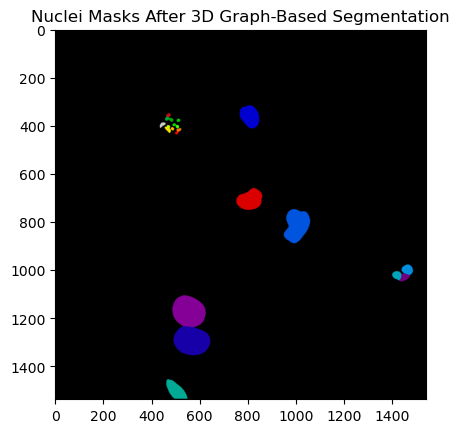

In [12]:
plt.imshow(nuclei_mask[8], cmap="nipy_spectral")
plt.title("Nuclei Masks After 3D Graph-Based Segmentation")
plt.show()

## Save the segmented masks

In [13]:
nuclei_mask_output = pathlib.Path(f"{mask_path}/nuclei_mask_new.tiff")
tifffile.imwrite(nuclei_mask_output, nuclei_mask)

In [ ]:
end_mem = psutil.Process(os.getpid()).memory_info().rss / 1024**2
end_time = time.time()
print(f"""
    Memory and time profiling for the run:\n
    Memory usage: {end_mem - start_mem:.2f} MB\n
    Time:\n
    --- %s seconds --- % {(end_time - start_time)}\n
    --- %s minutes --- % {((end_time - start_time) / 60)}\n
    --- %s hours --- % {((end_time - start_time) / 3600)}
""")


    Memory and time profiling for the run:

    Memory usage: 3301.46 MB

    Time:

    --- %s seconds --- % 173.10941123962402

    --- %s minutes --- % 2.885156853993734

    --- %s hours --- % 0.04808594756656223



: 